# Spectroscopic Case

In [2]:
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
import numpy as np
%matplotlib inline

from zbeamsfunctions import mu_w,likelihood,likelihood_spec,contour
from mcmcfunctions import mcmc,mcmc_spec

In [8]:
zt,z_obs,z2,mu_t,mu_obs,cor_type,cor_z  = np.loadtxt('fakedata_spectroscopic.txt',unpack=True)

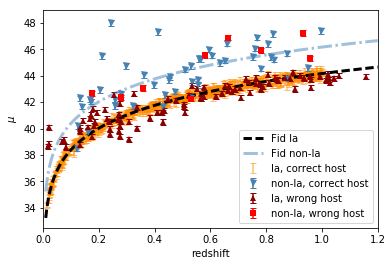

In [38]:
index_Ia = np.where((cor_type==1) & (cor_z==1))
index_nIa = np.where((cor_type==0) & (cor_z==1))
index_zIa = np.where((cor_type==1) & (cor_z==0))
index_znIa = np.where((cor_type==0) & (cor_z==0))

plt.errorbar(z_obs[index_Ia],mu_obs[index_Ia],yerr=0.2*np.ones(len(mu_obs[index_Ia])),
             marker='',ls='',color='darkorange', alpha=0.55,ms=7,capsize=3,
             label='Ia, correct host')
plt.errorbar(z_obs[index_nIa],mu_obs[index_nIa],yerr=0.2*np.ones(len(mu_obs[index_nIa])),
             marker='v',ls='',color='steelblue',markeredgecolor='none',ms=7,capsize=3,
             label='non-Ia, correct host')
plt.errorbar(z_obs[index_zIa],mu_obs[index_zIa],yerr=0.2*np.ones(len(mu_obs[index_zIa])),
             marker='^',ls='',color='darkred',markeredgecolor='none',ms=6,capsize=3,
             label='Ia, wrong host')
plt.errorbar(z_obs[index_znIa],mu_obs[index_znIa],yerr=0.2*np.ones(len(mu_obs[index_znIa])),
             marker='s',ls='',color='r',markeredgecolor='none',ms=6,capsize=3,
             label='non-Ia, wrong host')

z_vec = np.linspace(.01,1.2,1000)
mu_vec = np.vectorize(mu_w)
plt.plot(z_vec,mu_vec(z_vec,0.31,67.74,-1),'--k',lw=3,label='Fid Ia')
plt.plot(z_vec,mu_vec(z_vec,0.31,67.74,-1)+2,'-.',color='steelblue',lw=3,alpha=0.5,label='Fid non-Ia')

plt.xlabel('redshift')
plt.ylabel(r'$\mu$')
plt.legend()
plt.xlim([0,1.2])

plt.show()

In [4]:
#generating the unbiased mcmc chain

mcmc(50000,                          #number of steps
     likelihood,                     #which likelihood function to use
     'nobias',                       #bias: indicates the z dataset to use
     'nobias',                       #bias: indicates the mu dataset to use
     0.3,70,-1,                      #starting points (OMi,H0i,wi)
     0.0295,0.3965,0.0785,           #step sizes (omstep,H0step,wstep)
     'fakedata_spectroscopic.txt',   #input file (dataset)
     'chains/mcmc_chain_nobias.txt', #output file (chain)
     True)                           #show the statusbar 

Generating posterior
[##################################################]100%
done


In [3]:
#generating the biased mcmc chain

mcmc(50000,                            #number of steps
     likelihood,                       #which likelihood function to use
     'bias',                           #bias: indicates the z dataset to use
     'bias',                           #bias: indicates the mu dataset to use
     0.3,70,-1,                        #starting points (OMi,H0i,wi)
     0.0295,0.3965,0.0785,             #step sizes (omstep,H0step,wstep)
     'fakedata_spectroscopic.txt',     #input file (dataset)
     'chains/mcmc_chain_bias_muo.txt', #output file (chain)
     True)                             #show the statusbar 

Generating posterior
[##################################################]100%
done


In [3]:
#generating the zBEAMS mcmc chain

mcmc_spec(50000,                         #number of steps
         likelihood_spec,                #which likelihood function to use
         'bias',                         #bias: indicates the mu dataset to use
         0.3,70,-1,                      #starting points (OMi,H0i,wi)
         0.0295,0.3965,0.0785,           #step sizes (omstep,H0step,wstep)
         'fakedata_spectroscopic.txt',   #input file (dataset)
         'chains/mcmc_chain_zBEAMS.txt', #output file (chain)
         True)                           #show the statusbar 

Generating posterior
[##################################################]100%
done


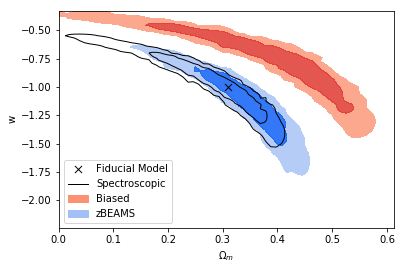

In [36]:
nb_mcmc_file = 'chains/mcmc_chain_nobias.txt'
bi_mcmc_file = 'chains/mcmc_chain_bias_muo.txt'
zb_mcmc_file = 'chains/mcmc_chain_zBEAMS.txt'

om_nb,H0_nb,w_nb = np.loadtxt(nb_mcmc_file, usecols=[0,1,2],unpack=True)
om_bi,H0_bi,w_bi = np.loadtxt(bi_mcmc_file, usecols=[0,1,2],unpack=True)
om_zb,H0_zb,w_zb = np.loadtxt(zb_mcmc_file, usecols=[0,1,2],unpack=True)

c_nb = np.loadtxt(nb_mcmc_file,usecols=[0,2])
c_bi = np.loadtxt(bi_mcmc_file,usecols=[0,2])
c_zb = np.loadtxt(zb_mcmc_file,usecols=[0,2])
N100_nb,N95_nb,N68_nb,X_nb,Y_nb,Z_nb = contour(c_nb,[0,1],smooth=21e4,line=True)
N100_bi,N95_bi,N68_bi,X_bi,Y_bi,Z_bi = contour(c_bi,[0,1],smooth=20e4,line=False)
N100_zb,N95_zb,N68_zb,X_zb,Y_zb,Z_zb = contour(c_zb,[0,1],smooth=16e4,line=False)
col0 = ('#a3c0f6','#0057f6')#light blue;dark blue
col1 = ('#fc9272','#de2d26')#light red;dark red
col2 = ('k','k')

cs0 = plt.contourf(X_bi,Y_bi,Z_bi,levels=[N95_bi,N68_bi,N100_bi],colors=col1,alpha=0.8)
cs1 = plt.contourf(X_zb,Y_zb,Z_zb,levels=[N95_zb,N68_zb,N100_zb],colors=col0,alpha=0.8)
cs2 = plt.contour(X_nb,Y_nb,Z_nb,levels=[N95_nb,N68_nb,N100_nb],colors=col2,alpha=1.0,linewidths=1)
cs3 = plt.scatter(0.31,-1,s=50,linewidth=1,marker='x',c='k',label='Fiducial Model')
plt.ylabel('w')
plt.xlabel(r'$\Omega_m$')

patch7 = mpatches.Patch(color=col0[0], label='zBEAMS')
patch8 = mpatches.Patch(color=col1[0], label='Biased',ls='solid',lw=1)
patch9 = mlines.Line2D([],[],color=col2[0],linewidth=1, label='Spectroscopic')
plt.legend(handles=[cs3,patch9,patch8,patch7],loc=3)
plt.show()